## Conv4_3D_res_v2
* key features
    * 4-20 Conv layers
        * 2 residual parts of (Convolution block + 2 Identity blocks)
    * 2 dropout layers (rate=0.7) + 2 dropout (rate=0.4) after residual Convs
    * SWISH activation functions
    * Nadam optimizer
    * 6 models trained on 6 different subsets of data for systematic error analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import os, re, gc
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from cnn_utils import *

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import ZeroPadding3D, Conv3D, MaxPooling3D, Concatenate, Add
from keras import optimizers
from keras.models import Model, load_model
from keras.constraints import MaxNorm

import tensorflow as tf
import keras.backend as K
from keras.utils.generic_utils import get_custom_objects
K.set_image_data_format('channels_last')

tf.logging.set_verbosity(tf.logging.ERROR)
K.get_session().list_devices()

Using TensorFlow backend.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 7823363877386851352),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1258758747342661075),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 14321268319938600955),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 7925845197, 17368503731330567843)]

In [2]:
[d.device_type+' '+str(d.memory_limit_bytes//1024**2)+' Mb' for d in K.get_session().list_devices() if "GPU" in d.name]

['XLA_GPU 16384 Mb', 'GPU 7558 Mb']

In [3]:
#from tensorflow.python.client import device_lib
# TensorFlow wizardry
#config = tf.ConfigProto() 
# Don't pre-allocate memory; allocate as-needed
#config.gpu_options.allow_growth = True 
# Only allow a total of half the GPU memory to be allocated
#config.gpu_options.per_process_gpu_memory_fraction = 0.5 
# Create a session with the above options specified.
#K.tensorflow_backend.set_session(tf.Session(config=config))

In [4]:
def swish(x):
    """
    x*sigmoid(x)
    """
    return (K.sigmoid(x) * x)
# adding a custom activation function
get_custom_objects().update({'swish': swish})


def identity_block(X, f, filters, stage, block):
    """    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_D_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_D, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv3D(filters = F1, kernel_size = 1, strides = 1, padding = 'valid', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
    X = Activation('swish')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv3D(filters=F2, kernel_size= f, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name= conv_name_base+'2b')(X)
    X = BatchNormalization(axis=3, name= bn_name_base+'2b')(X)
    X = Activation('swish')(X)

    # Third component of main path (≈2 lines)
    X = Conv3D(filters=F3, kernel_size=1, padding='valid', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name=conv_name_base+'2c')(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+'2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a SWISH activation (≈2 lines)
    X = Add()([X, X_shortcut])#X+X_shortcut
    X = Activation('swish')(X)
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_D_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_D, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv3D(F1, 1, strides = s, kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
    X = Activation('swish')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv3D(F2, f, kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), padding='same', name=conv_name_base+'2b')(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+'2b')(X)
    X = Activation('swish')(X)

    # Third component of main path (≈2 lines)
    X = Conv3D(F3, 1, kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name=conv_name_base+'2c')(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+'2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv3D(F3, 1, strides=s, kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name=conv_name_base+'1')(X_shortcut)
    X_shortcut = BatchNormalization(axis=-1, name=bn_name_base+'1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a SWISH activation (≈2 lines)
    X = Add()([X, X_shortcut]) #X+X_shortcut
    X = Activation('swish')(X)
    
    X = Dropout(rate=0.4, name='drop'+str(stage)+block)(X)
    
    return X

def conv_res_3d_model(input_shape=(32,32,8,1)):
    
    X_input = Input(input_shape)

    X = Conv3D(64, 3, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), activation='swish', name='conv1_1')(X_input)
    X = Conv3D(64, 3, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), activation='swish', name='conv1_2')(X)
    X = MaxPooling3D(name='pool1')(X)
    #print('conv1\t',X.get_shape())
    
    #X = Dropout(rate=0.3, name='drop_start')(X)
    
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    #print('conv2\t',X.get_shape())
    
    X = Dropout(rate=0.7, name='drop_middle')(X)
    
    X = convolutional_block(X, f = 3, filters = [128,128, 512], stage = 3, block='a')
    X = identity_block(X, 3, [128,128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128,128, 512], stage=3, block='c')
    X = MaxPooling3D(padding='same', name='pool3')(X)
    #print('conv3\t',X.get_shape())
    
    X = Dropout(rate=0.7, name='drop')(X)
    
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='class')(X)
    
    return Model(inputs = X_input, outputs = X, name='conv_res_model')

In [5]:
X, y, shuffs = {},{},{}
conv4_3d_res, hist_roc, hist = {},{},{}
class_names = ['C100keV', 'C60keV', 'C30keV']
dset = '/mnt/ML-drive/Artem/Python/NEWS/data/dataset_clean.h5'
nadamka = optimizers.Nadam(lr=1e-4, beta_1=0.95)
N_ep = 50; batch = 256; i=0; n_fold = 5
load_s = []
for n in class_names:
    load_s += [(n,str(i)) for i in range(1,n_fold+1)]
print('Training in ',n_fold,' folds for ',N_ep,' epochs with batch_size =',batch)
print('The optimizer is Nadam:\n\tinitial lr =',K.eval(nadamka.lr),'\tbeta_1 =',K.eval(nadamka.beta_1),
      '\tbeta_2 =',K.eval(nadamka.beta_2),'\n')

start = datetime.now()
for s, p in load_s:
    if not s in X.keys():
        print('\n\tFor validation on '+s+' vs gamma')
        X[s], y[s], shuffs[s] = load_data_v2(classes={'s_'+s:'full', 'b_gamma':'full'}, tr_val_test=[False,True,False],
                                             im_ft=[True,False], path_h5=dset, shuf_ind={}, verbose=1)
        i=0; print('')
    i+=1; print('FOLD '+str(i)+':\t'+s+' part '+p+'/'+str(n_fold)+' vs gamma part '+p+'/'+str(n_fold))
    fold = datetime.now()
    X[s+p], y[s+p], shuffs[s+p] = load_data_v2(classes={'s_'+s:p, 'b_gamma':p}, n_folds=n_fold, tr_val_test=[True,False,False],
                                                     im_ft=[True,False], path_h5=dset, shuf_ind={}, verbose=1)
    conv4_3d_res[s+p] = conv_res_3d_model(input_shape=X[s+p]['/images/train'].shape[1:])
    conv4_3d_res[s+p].compile(optimizer=nadamka, loss='binary_crossentropy')
    hist_roc[s+p] = call_roc_hist()
    hist[s+p] = conv4_3d_res[s+p].fit(x=X[s+p]['/images/train'], y=y[s+p]['/images/train'], batch_size=batch, epochs=N_ep,
                            validation_data=(X[s]['/images/val'],y[s]['/images/val']), callbacks=[hist_roc[s+p]], verbose=0)
    print('\tfold training time ', datetime.now()-fold)
    print('\ttraining loss: ',np.around(hist[s+p].history['loss'][-1],decimals=4),
          '\t validation loss: ',np.around(hist[s+p].history['val_loss'][-1],decimals=4),
          '\tROC AUC: ',np.around(hist_roc[s+p].val_aucs[-1],decimals=4))
    print('')
print('\nTotal training time ', datetime.now()-start)

Training in  4  folds for  10  epochs with batch_size = 256
The optimizer is Nadam:
	initial lr = 1e-04 	beta_1 = 0.95 	beta_2 = 0.999 


	For validation on C100keV vs gamma
Number of C100keV samples: 	 12982
Number of gamma samples: 	 8843

FOLD 1:	C100keV part 1/4 vs gamma part 1/4
Number of C100keV samples: 	 78771
Number of gamma samples: 	 53655
Train on 132426 samples, validate on 21825 samples
Epoch 1/10
132426/132426 [==============================] - 385s - loss: 0.5141 - val_loss: 0.3979
Epoch 2/10
132426/132426 [==============================] - 377s - loss: 0.2493 - val_loss: 0.1734
Epoch 3/10
132426/132426 [==============================] - 377s - loss: 0.1918 - val_loss: 0.1612
Epoch 4/10
132426/132426 [==============================] - 377s - loss: 0.1348 - val_loss: 0.2776
Epoch 5/10
132426/132426 [==============================] - 378s - loss: 0.1185 - val_loss: 0.1184
Epoch 6/10
132426/132426 [==============================] - 377s - loss: 0.1064 - val_loss: 0.0903
Ep

In [6]:
with open('outputs/conv4_3d_res/v2/notes.txt','a') as ftxt:
    ftxt.write('''
    * '''+str(N_ep)+''' epochs. Each subset = 1/'''+str(n_fold)+''' (Signal_class) vs 1/'''+str(n_fold)+''' (Gamma_class)
    ''')
for s in hist.keys():
    np.savetxt('outputs/conv4_3d_res/v2/'+s[:-1]+'_'+s[-1]+'_roc_auc_'+str(N_ep)+'.txt', hist_roc[s].val_aucs)
    np.savetxt('outputs/conv4_3d_res/v2/'+s[:-1]+'_'+s[-1]+'_loss_train_'+str(N_ep)+'.txt', hist[s].history['loss'])
    np.savetxt('outputs/conv4_3d_res/v2/'+s[:-1]+'_'+s[-1]+'_loss_val_'+str(N_ep)+'.txt', hist[s].history['val_loss']) 
    conv4_3d_res[s].save('networks/res_v2/e'+str(N_ep)+'/conv4_3d_res_'+s[:-1]+'_'+s[-1]+'.h5')
    

In [7]:
hist.keys()

dict_keys(['C100keV1', 'C100keV2', 'C100keV3', 'C100keV4', 'C60keV1', 'C60keV2', 'C60keV3', 'C60keV4', 'C30keV1', 'C30keV2', 'C30keV3', 'C30keV4'])

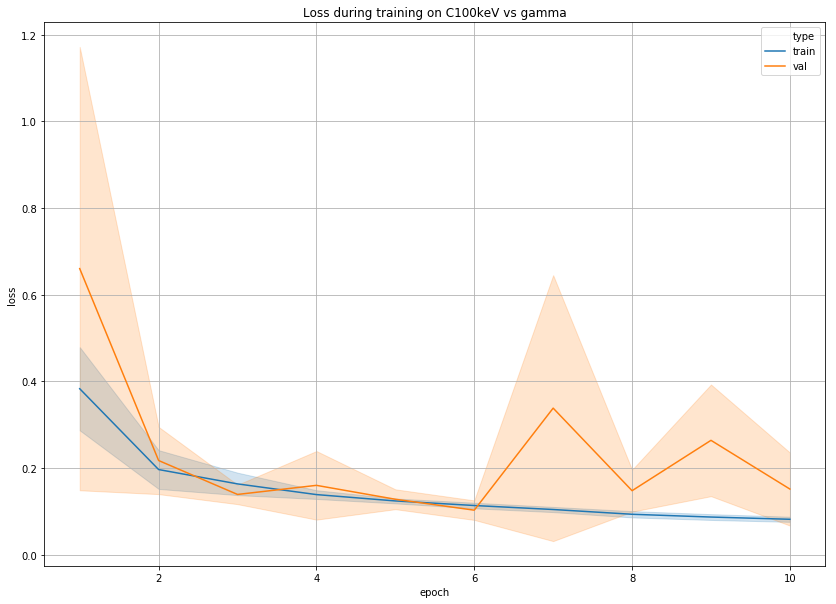

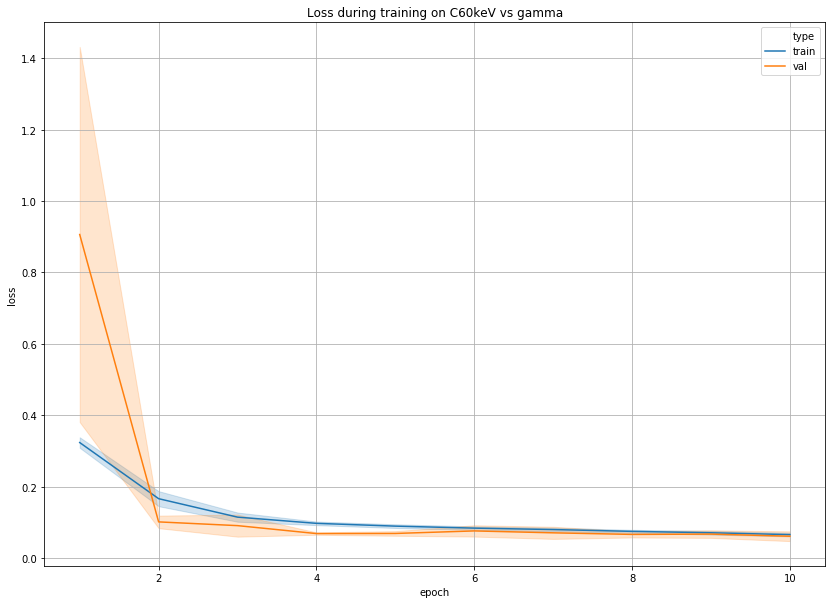

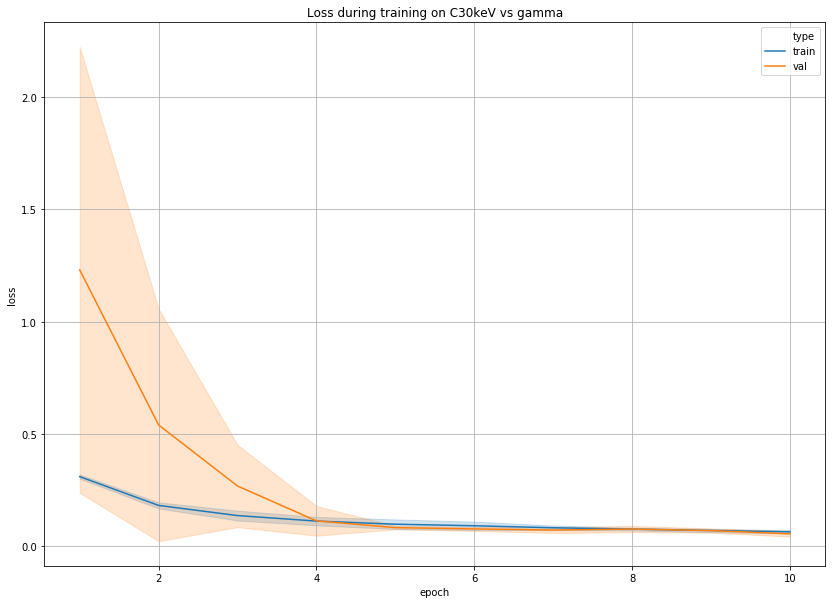

In [14]:
loss = {}
loss['epoch'], loss['type'], loss['loss'], loss['class'] = [],[],[],[]
for n in class_names:
    for s in [k for k in hist.keys() if n in k]:
        e = 1
        for l, vl in zip(hist[s].history['loss'],hist[s].history['val_loss']):
            loss['epoch'].append(e); loss['type'].append('train'); loss['loss'].append(l); loss['class'].append(n)
            loss['epoch'].append(e); loss['type'].append('val'); loss['loss'].append(vl); loss['class'].append(n)
            e += 1
loss = pd.DataFrame(data=loss)

for n in class_names:
    plt.figure(figsize=(14,10))
    sns.lineplot(x='epoch',y='loss',hue='type', data=loss[loss['class']==n], ci='sd')
    plt.grid()
    plt.title('Loss during training on '+n+' vs gamma')
    plt.show()

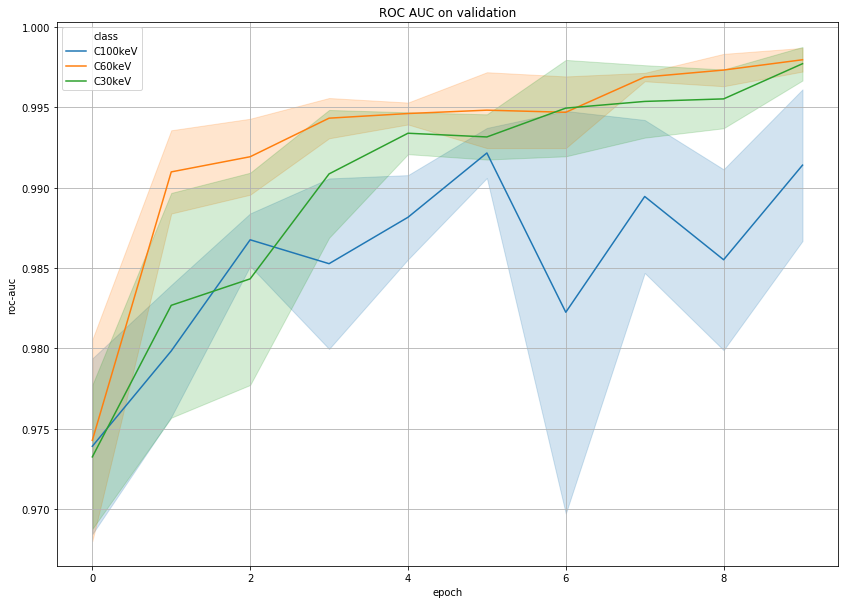

In [15]:
aucs = {}
aucs['epoch'], aucs['roc-auc'], aucs['class'] = [],[],[]
for n in class_names:
    for s in [k for k in hist_roc.keys() if n in k]:
        for e, au in enumerate(hist_roc[s].val_aucs):
            aucs['epoch'].append(e); aucs['roc-auc'].append(au); aucs['class'].append(n)
aucs = pd.DataFrame(data=aucs)

plt.figure(figsize=(14,10))
sns.lineplot(x='epoch',y='roc-auc', hue='class', data=aucs, ci='sd')
plt.grid()
_ = plt.title('ROC AUC on validation')